# <center>Cost Sensitive Logistic Regression Implementation

### Importing the necessary Libraries

In [2]:
# Make sure you have these two libraries installed on your system before running the above cell
# ! pip install pyea
# ! pip install joblib

In [3]:
# importing all the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from pyea import GeneticAlgorithmOptimizer

### Loading the data from the "costsensitivedata.csv" file and displaying it

In [4]:
df = pd.read_csv('costsensitivedata.csv')
df

,Status,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,FNC
0,0,2,21,0.0,0.00000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000e+00
1,1,23,0,0.0,0.04400,0.00000,0.0,0.0000,0.306179,0.000000,0.000000e+00
2,0,1,22,0.0,0.00000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000e+00
3,1,5,18,0.0,0.00000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000e+00
4,0,1,22,0.0,0.00000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
147631,0,4,19,1.0,1.09306,4.25256,0.0,0.0000,21.946737,2.679667,6.092077e+05
147632,0,16,7,1.0,0.00000,0.00000,0.0,0.0000,0.000000,2.549239,6.996571e+05
147633,0,2,21,1.0,4.64145,5.47616,0.0,25.5783,48.283019,2.442827,9.658214e+05
147634,0,3,20,1.0,0.00000,0.40989,0.0,0.0000,0.694601,4.078739,1.612465e+06


In [5]:
# checking the distribution of the class label "Status"
np.unique(df['Status'],return_counts=True)

(array([0, 1], dtype=int64), array([103554,  44082], dtype=int64))

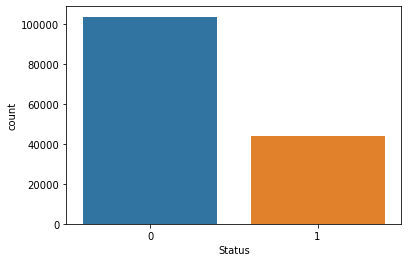

In [6]:
sns.countplot(data = df, x = 'Status')
plt.show()

### As can be seen from the above plot that the distribution of the data is not balanced. 103554 belong to one class and 44082 belong to another

In [7]:
# all the features except the class label
X = df.drop('Status',axis = 1)

In [8]:
# class label
y = df['Status']

### Calculating the cost loss from the cost function discussed in class

![Img](cost_function.jpg "Title")

### Image taken from Alejandro CORREA BAHNSEN Research Paper

In [9]:
# calculating the cost using the cost function discussed in the class(optimized one)
def get_cost_loss_optimized(y_true, y_pred, cost_matrix):
    
    y_true = np.array(y_true).astype(np.float)
    y_pred = np.array(y_pred).astype(np.float)
    total_cost = y_true * ((1 - y_pred) * cost_matrix[:, 1] + y_pred * cost_matrix[:, 2]) + (1 - y_true) * (y_pred * cost_matrix[:, 0] + (1 - y_pred) * cost_matrix[:, 3])
    return np.sum(total_cost)

### Cost loss using the naive version of Logistic Regression

In [10]:
def get_cost_loss_naive(y_true,y_pred,cost_matrix):
    cost_naive = min(get_cost_loss_optimized(y_true, np.zeros(len(y_true)), cost_matrix),
                    get_cost_loss_optimized(y_true, np.ones(len(y_true)), cost_matrix))
    return cost_naive

### Function to calculate the savings score which is  defined as the cost of the optimized algorithm versus the cost of the naive algorithm

### Saving Score = 1 - (cost loss using optimized function / cost loss using naive function)

In [11]:
def get_savings_score(y_true, y_pred, cost_matrix):

    # Calculate the cost using the naive prediction approach
    cost_naive = get_cost_loss_naive(y_true,y_pred,cost_matrix)
    cost_optimized = get_cost_loss_optimized(y_true, y_pred, cost_matrix)
    return 1.0 - cost_optimized / cost_naive

### Sigmoid Function

In [12]:
# function to calculate the sigmoid function 
def sigmoid_function(x):
    return 1 / (1 + np.exp(-x))

### Function to compute the Logistic cost loss

In [13]:
def logit_cost_loss_for_each_iteration(w_trans, X, y, cost_matix, alpha):
    
    C = 0
    if w_trans.size == X.shape[1] + 1:
        C = w_trans[-1]
        w_trans = w_trans[:-1]

    y_cap = np.dot(X, w_trans) + C
    y_prob = sigmoid_function(y_cap)
    res = (get_cost_loss_optimized(y, y_prob, cost_matix) / X.shape[0]) + (0.5 * alpha * np.dot(w_trans, w_trans))
    return res

def total_logistic_cost_loss(w_trans, X, y, cost_matrix, alpha):
    
    if w_trans.shape[0] == w_trans.size:
        # Only evaluating one instance of w_trans here
        return logit_cost_loss_for_each_iteration(w_trans, X, y, cost_matix, alpha)

    else:
        # Evaluating an array of w_trans here
        res = np.zeros(w_trans.shape[0])

        for i in range(w_trans.shape[0]):
            res[i] = logit_cost_loss_for_each_iteration(w_trans[i], X, y, cost_matrix, alpha)

        return res

### Since this optimized cost function is not convex, we estimate the parameters with genetic algorithms
### We have used GeneticAlgorithmOptimizer provided by the pyea module

In [14]:
class Cost_Sensitive_Logistic_Regression():

    def train(self, X, y, cost_matrix):

        w_trans = np.zeros(X.shape[1] + 1)
        #running the GeneticAlgorithmOptimizer for 100 iterations, with number of chromosomes as 100 and per_mutaions as 0.25
        genetic_model = GeneticAlgorithmOptimizer(total_logistic_cost_loss, w_trans.shape[0],iters = 100, n_chromosomes = 100,per_mutations = 0.25,type_ = 'cont',fargs=(X, y, cost_matrix, 1))
        genetic_model.fit()

        self.coefficient = genetic_model.x[:-1]
        self.intercept = genetic_model.x[-1]
            
    def get_predicted_prob(self, X):
        
        y_prob = np.zeros((X.shape[0], 2))
        y_prob[:, 1] = sigmoid_function(np.dot(X, self.coefficient) + self.intercept)
        y_prob[:, 0] = 1 - y_prob[:, 1]
        return y_prob

    def predict(self, X):
        
        return np.floor(self.get_predicted_prob(X)[:, 1] + 0.5)

### Splitting the data into train test split (70:30) where 70% of the data is used for training the model

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

### Preparing the Cost Matrix

In [16]:
len(df)

147636

### Here we are taking the following costs
### FNC = FNC values from the dataset provided
### FPC = 150
### TPC = 150
### TNC = 0

### Our Cost Matrix is of the form
### [[FPC,FNC,TPC,TNC]]

### Preparing the Cost Matrix

In [17]:
# 147636 is the total number of nodes
FP = [150] * 147636
TP = [150] * 147636
TN = [0] * 147636

cost_mat_df = pd.DataFrame(FP, columns = ['FP'])
cost_mat_df['FN'] = df['FNC']
cost_mat_df['TP'] = TP
cost_mat_df['TN'] = TN
cost_mat_df = cost_mat_df.astype(float)
cost_mat = cost_mat_df.values

### Splitting the Cost Matrix into Train and Test splits

In [18]:
# splitting the cost matrix into train and test splits
cost_mat_df_train, cost_mat_df_test = train_test_split(cost_mat_df,test_size=0.30, random_state=101)

In [19]:
# we now have our cost matrix ready
cost_mat_train = cost_mat_df_train.values
cost_mat_test = cost_mat_df_test.values

## First Check our results on the Naive Logistic Regression(Sklearn)

In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [21]:
get_savings_score(y_test,pred,cost_mat_test)

0.4812957184786977

## Using Naive Logistic Regression we are getting a Saving's Score between 0.48-0.49

### Let's see if we can imporove it using our Cost Sensitive Logistic Regression Model

### Training the model and making predictions

In [22]:
model = Cost_Sensitive_Logistic_Regression()
model.train(X_train,y_train,cost_mat_train)
pred = model.predict(X_test)

### Cost loss Using the naive cost function

In [23]:
get_cost_loss_naive(y_test,pred,cost_mat_test)

6643650.0

### Cost loss using the optimized cost function

In [24]:
get_cost_loss_optimized(y_test,pred,cost_mat_test)

1017974.5393050001

### As can be seen we have significantly reduced the cost loss

## Calculating the Saving's Score using Cost Sensitive Logistic Regression Model

In [25]:
get_savings_score(y_test,pred,cost_mat_test)

0.8467748091327809

## We are getting a Saving's Score of between 0.82-0.85 which is a huge improvement compared to the normal Logistic Regression which is giving between 0.48-0.49

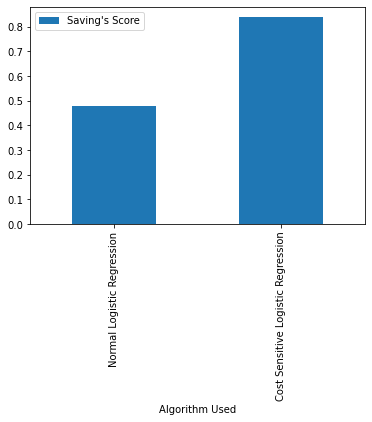

In [26]:
data=[["Normal Logistic Regression",0.48],
      ["Cost Sensitive Logistic Regression",0.84]]

df=pd.DataFrame(data,columns=["Algorithm Used","Saving's Score"])
df.plot(x="Algorithm Used", y=["Saving's Score"], kind="bar")
plt.show()